### Individual Assignment: Natural Language Processing. 

#### Class: MBD 2020, S2
#### Team Members:  
Karen Cendales

Amritesh Palani 

### 1. Competition Description

Twitter has become an important communication channel in times of emergency.The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. Take this example:

The author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine.In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified. If this is your first time working on an NLP problem, we've created a quick tutorial to get you up and running.

Disclaimer: The dataset for this competition contains text that may be considered profane, vulgar, or offensive.

### 2. Given.  
We are whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.
#### Files:
train.csv - the training set
test.csv - the test set
sample_submission.csv - a sample submission file in the correct format
#### Columns:
id - a unique identifier for each tweet

text - the text of the tweet

location - the location the tweet was sent from (may be blank)

keyword - a particular keyword from the tweet (may be blank)

target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

### 3. Data Understanding. 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
train_df[train_df["target"] == 0]["text"].values[1]

'I love fruits'

In [6]:
train_df[train_df["target"] == 1]["text"].values[1]


'Forest fire near La Ronge Sask. Canada'

### 3. Data Cleaning. 

In [7]:
train_df['location'].isnull().sum()

2533

In [8]:
train_df['keyword'].isnull().sum()

61

In [9]:
train_df['text'].isnull().sum()

0

In [10]:
train_df['keyword'].fillna('',inplace=True)
train_df['keyword'] = train_df['keyword'].map(lambda x:x.replace('%20', ' '))
test_df['keyword'].fillna('',inplace=True)
test_df['keyword'] = test_df['keyword'].map(lambda x:x.replace('%20', ' '))

In [11]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [12]:
import re
import string
train_df['text'] = train_df['text'].apply(lambda x: clean_text(x))
test_df['text'] = test_df['text'].apply(lambda x: clean_text(x))

In [13]:
train_df.isnull().sum()

id             0
keyword        0
location    2533
text           0
target         0
dtype: int64

In [14]:
train_df.head()

,id,keyword,location,text,target
0,1,,NaN,our deeds are the reason of this earthquake ma...,1
1,4,,NaN,forest fire near la ronge sask canada,1
2,5,,NaN,all residents asked to shelter in place are be...,1
3,6,,NaN,people receive wildfires evacuation orders in...,1
4,7,,NaN,just got sent this photo from ruby alaska as s...,1


In [15]:
import sys
print(sys.executable)

/opt/anaconda3/bin/python


In [23]:
#!/opt/anaconda3/bin/python -m pip install wordcloud

In [30]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [31]:
#selecting column text as series and converting it into numpy array
train_df[train_df["target"] == 0].text.to_numpy()

array(['whats up man', 'i love fruits', 'summer is lovely', ...,
       'these boxes are ready to explode exploding kittens finally arrived gameofkittens explodingkittens\x89û ',
       'sirens everywhere',
       'i just heard a really loud bang and everyone is asleep great'],
      dtype=object)

In [32]:
# conveting from numpy array to list
a = train_df[train_df["target"] == 0].text.to_numpy().tolist()

In [33]:
a =  " ".join(a)

In [34]:
b = train_df[train_df["target"] == 1].text.to_numpy().tolist()
b = " ".join(b)
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
stopwords = list(ENGLISH_STOP_WORDS)

stopwords.append('http')  
stopwords.append('https')  
stopwords.append('CO')  
stopwords.append('û_')
a = WordCloud(stopwords=stopwords, background_color="white").generate(a)
b = WordCloud(stopwords=stopwords, background_color="white").generate(b)
a

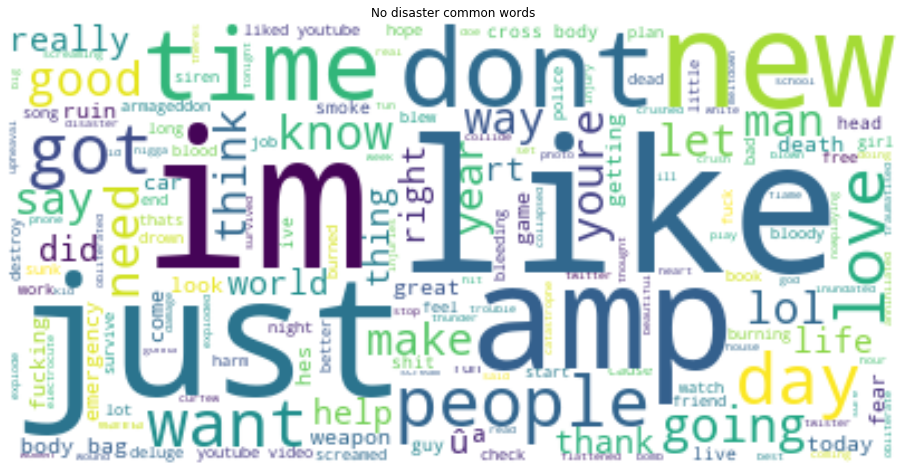

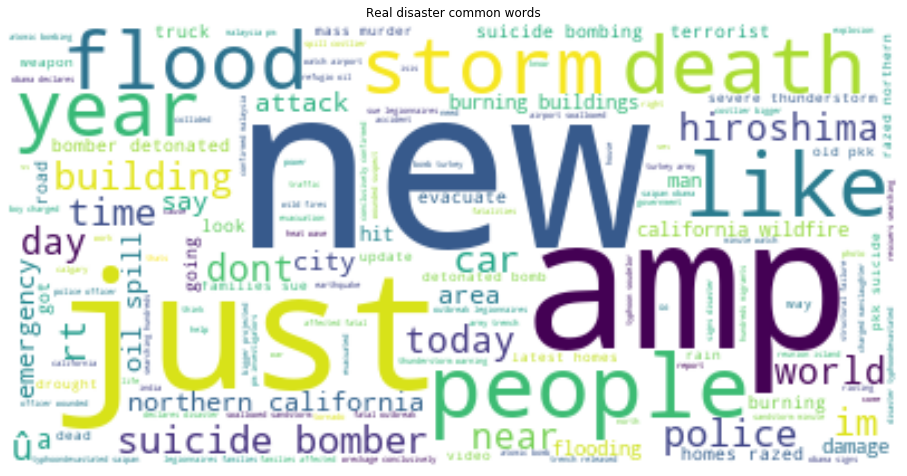

In [35]:
def show_word_cloud(cloud, title):
    plt.figure(figsize = (16, 10))
    plt.imshow(cloud, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show();

show_word_cloud(a, "No disaster common words")
show_word_cloud(b, "Real disaster common words")

### 4. Data Pre-processing. 

#### Buliding Vectors/ Tokenization.

In [36]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

countvector = CountVectorizer(min_df=2,ngram_range=(1, 2), stop_words=stopwords)
vectorized_train = countvector.fit_transform(train_df['text'])

len(countvector.vocabulary_)

10479

In [37]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import StratifiedKFold,ShuffleSplit

In [38]:
count_vectorizer = feature_extraction.text.CountVectorizer()

## let's get counts for the first 5 tweets in the data
example_train_vectors = count_vectorizer.fit_transform(train_df["text"][0:5])

In [39]:
print(example_train_vectors[0].todense().shape)
print(example_train_vectors[0].todense())

(1, 52)
[[0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0
  0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0]]


The above tells us that,there are 54 unique words (or "tokens") in the first five tweets.
The first tweet contains only some of those unique tokens - all of the non-zero counts above are the tokens that DO exist in the first tweet.
Now let's create vectors for all of our tweets.

In [40]:
train_vectors = count_vectorizer.fit_transform(train_df["text"])

## note that we're NOT using .fit_transform() here. Using just .transform() makes sure
# that the tokens in the train vectors are the only ones mapped to the test vectors - 
# i.e. that the train and test vectors use the same set of tokens.
test_vectors = count_vectorizer.transform(test_df["text"])

#### 4.1 POS Tagging.

#### 4.2 Parsing. 

#### 4.3 N-grams. 

### 5. Modeling.

#### 5.1 Building a baseline model- Linear ridge classifier. 

As we mentioned above, we think the words contained in each tweet are a good indicator of whether they're about a real disaster or not. The presence of particular word (or set of words) in a tweet might link directly to whether or not that tweet is real.

What we're assuming here is a linear connection. So let's build a linear model and see!

In [41]:
## Our vectors are really big, so we want to push our model's weights
## toward 0 without completely discounting different words - ridge regression 
## is a good way to do this.
clf = linear_model.RidgeClassifier()

In [42]:
scores = model_selection.cross_val_score(clf, train_vectors, train_df["target"], cv=3, scoring="f1")
scores

array([0.61064718, 0.55390702, 0.6195811 ])

The above scores aren't terrible! It looks like our assumption will score roughly 0.65 on the leaderboard. There are lots of ways to potentially improve on this (TFIDF, LSA, LSTM / RNNs, the list is long!), we will try them in the later sets of code. 

In the meantime, let's do predictions on our training set and build a submission for the competition.

In [43]:
clf.fit(train_vectors, train_df["target"])

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)

#### Scoring. 

In [44]:
scores = {}

cv = StratifiedKFold(n_splits=5)
scores["Stratifid K Fold"] = cross_val_score(LogisticRegression(),vectorized_train , train_df["target"],scoring="f1", cv=cv)
scores["Stratifid K Fold"] = np.mean(scores["Stratifid K Fold"])

In [45]:
cv = ShuffleSplit(n_splits =5, test_size = 0.2,random_state=0)
scores["Shuffle Split"] = cross_val_score(LogisticRegression(),vectorized_train , train_df["target"],scoring="f1", cv=cv)
scores["Shuffle Split"] = np.mean(scores["Shuffle Split"])

In [46]:
scores

{'Stratifid K Fold': 0.5756872827314427, 'Shuffle Split': 0.7542502572314014}

#### 5.3 SVM as a classifier.

In [47]:
cv = ShuffleSplit(n_splits =5, test_size = 0.2,random_state=0)
scores["Shuffle Split with svm"] = cross_val_score(svm.SVC(),vectorized_train , train_df["target"],scoring="f1", cv=cv)
scores["Shuffle Split with svm"] = np.mean(scores["Shuffle Split with svm"])

In [48]:
scores

{'Stratifid K Fold': 0.5756872827314427,
 'Shuffle Split': 0.7542502572314014,
 'Shuffle Split with svm': 0.7428731264862012}

#### TD-IF weighting

In [49]:
countvector = TfidfVectorizer(min_df=2,ngram_range=(1, 2), stop_words=stopwords)
vectorized_train = countvector.fit_transform(train_df['text'])
len(countvector.vocabulary_)

10479

#### k-fold CV

In [50]:
cv = StratifiedKFold(n_splits=5)
scores["Stratifid K Fold with tfidf"] = cross_val_score(LogisticRegression(),vectorized_train , train_df["target"],scoring="f1", cv=cv)
scores["Stratifid K Fold with tfidf"] = np.mean(scores["Stratifid K Fold with tfidf"])

In [51]:
scores

{'Stratifid K Fold': 0.5756872827314427,
 'Shuffle Split': 0.7542502572314014,
 'Shuffle Split with svm': 0.7428731264862012,
 'Stratifid K Fold with tfidf': 0.5342365058775289}

In [52]:
cv = ShuffleSplit(n_splits=5,test_size=0.2,random_state =0)
scores["Shuffle split with tfidf"] = cross_val_score(LogisticRegression(),vectorized_train , train_df["target"],scoring="f1", cv=cv)
scores["Shuffle split with tfidf"] = np.mean(scores["Shuffle split with tfidf"])

In [53]:
scores

{'Stratifid K Fold': 0.5756872827314427,
 'Shuffle Split': 0.7542502572314014,
 'Shuffle Split with svm': 0.7428731264862012,
 'Stratifid K Fold with tfidf': 0.5342365058775289,
 'Shuffle split with tfidf': 0.7498349054976279}

#### Logistic regression as a text classifier.

In [54]:
from sklearn.metrics import f1_score
clf = LogisticRegression()
clf.fit(vectorized_train , train_df["target"])
predicted = clf.predict(vectorized_train)
scores["logistic regression without cross validation over tfidf"] = f1_score(predicted,train_df["target"])

In [55]:
scores

{'Stratifid K Fold': 0.5756872827314427,
 'Shuffle Split': 0.7542502572314014,
 'Shuffle Split with svm': 0.7428731264862012,
 'Stratifid K Fold with tfidf': 0.5342365058775289,
 'Shuffle split with tfidf': 0.7498349054976279,
 'logistic regression without cross validation over tfidf': 0.845018450184502}

#### Additional Models with cross-overs.

In [56]:
clf =svm.SVC()
clf.fit(vectorized_train , train_df["target"])
predicted = clf.predict(vectorized_train)
scores["svm without cross validation over tfidf"] = f1_score(predicted,train_df["target"])

In [57]:
scores

{'Stratifid K Fold': 0.5756872827314427,
 'Shuffle Split': 0.7542502572314014,
 'Shuffle Split with svm': 0.7428731264862012,
 'Stratifid K Fold with tfidf': 0.5342365058775289,
 'Shuffle split with tfidf': 0.7498349054976279,
 'logistic regression without cross validation over tfidf': 0.845018450184502,
 'svm without cross validation over tfidf': 0.9401273885350319}

In [58]:
countvector = CountVectorizer(min_df=2,ngram_range=(1, 2), stop_words=stopwords)
vectorized_train = countvector.fit_transform(train_df['text'])
len(countvector.vocabulary_)

10479

In [59]:
clf = LogisticRegression()
clf.fit(vectorized_train , train_df["target"])
predicted = clf.predict(vectorized_train)
scores["logistic regression without cross validation over cv"] = f1_score(predicted,train_df["target"])

In [60]:
scores

{'Stratifid K Fold': 0.5756872827314427,
 'Shuffle Split': 0.7542502572314014,
 'Shuffle Split with svm': 0.7428731264862012,
 'Stratifid K Fold with tfidf': 0.5342365058775289,
 'Shuffle split with tfidf': 0.7498349054976279,
 'logistic regression without cross validation over tfidf': 0.845018450184502,
 'svm without cross validation over tfidf': 0.9401273885350319,
 'logistic regression without cross validation over cv': 0.9130224302081652}

In [61]:
clf =svm.SVC()
clf.fit(vectorized_train , train_df["target"])
predicted = clf.predict(vectorized_train)
scores["svm without cross validation over cv"] = f1_score(predicted,train_df["target"])

In [62]:
scores

{'Stratifid K Fold': 0.5756872827314427,
 'Shuffle Split': 0.7542502572314014,
 'Shuffle Split with svm': 0.7428731264862012,
 'Stratifid K Fold with tfidf': 0.5342365058775289,
 'Shuffle split with tfidf': 0.7498349054976279,
 'logistic regression without cross validation over tfidf': 0.845018450184502,
 'svm without cross validation over tfidf': 0.9401273885350319,
 'logistic regression without cross validation over cv': 0.9130224302081652,
 'svm without cross validation over cv': 0.9003120381014944}

In [63]:
len(countvector.vocabulary_)

10479

In [64]:
vectorized_test = countvector.transform(test_df['text'])

In [65]:
clf = svm.SVC()
clf.fit(vectorized_train,train_df['target'])
predicted = clf.predict(vectorized_test)

#### 5.2 Naive-Bayes.

### Final Results. 

In [134]:
scores

{'Stratifid K Fold': 0.5756872827314427,
 'Shuffle Split': 0.7542502572314014,
 'Shuffle Split with svm': 0.7428731264862012,
 'Stratifid K Fold with tfidf': 0.5342365058775289,
 'Shuffle split with tfidf': 0.7498349054976279,
 'logistic regression without cross validation over tfidf': 0.845018450184502,
 'svm without cross validation over tfidf': 0.9401273885350319,
 'logistic regression without cross validation over cv': 0.9130224302081652,
 'svm without cross validation over cv': 0.9003120381014944}

### Exctracting Output.  

In [135]:
#submission_df = pd.read_csv("sample_submission.csv")

In [136]:
#submission_df['target'] = predicted
#submission_df.to_csv("Submitted.csv",index=False,header = True)

In [138]:
#submission_df.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1
